# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


# f'20210209-0234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=7 res=456'

# 8

<br>
<br>

In [2]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F


%matplotlib inline

# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')


ARCH = 'efficientnet_b4'  # resnet101

CHOSEN_SAMPLE_SIZE = 1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
# TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.1)  # number of images per category to put in the test set
FROZEN_EPOCHS = 3  # 1
EPOCHS = 60  # 4
BATCH_SIZE = 12  # 16
# RESOLUTION = round(380 * 1.2)  # 300
RESOLUTION=300
PRETRAINED_FLAG = False  # actually False - just to make sure we train a few times before attempting to find LR

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

# RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'
RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")


RUN_NAME = '20210212-0154 - arch=efficientnet_b4 - samples=1800 frozen=3 epochs=60 bs=12 res=300'


In [3]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.2
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

## Utility Functions to use timm models on FastAI

written by Zach Mueller / walkwithfastai.com



In [4]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=False, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model


def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

<br>
<br>

### Add a Module for Gradient Checkpointing

In [5]:


from torch.utils.checkpoint import checkpoint, checkpoint_sequential

class CheckpointModule(Module):
    def __init__(self, module, num_segments=1):
        assert num_segments == 1 or isinstance(module, nn.Sequential)
        self.module = module
        self.num_segments = num_segments

    def forward(self, *inputs):
        if self.num_segments > 1:
            return checkpoint_sequential(self.module, self.num_segments, *inputs)
        else:
            return checkpoint(self.module, *inputs)
        
        
    
def convert_seq_chkpt(model, layer_type_old):  
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_seq_chkpt(module, layer_type_old) 

        if type(module) == layer_type_old:
#             num_chkpt += 1
            layer_old = module
#             if len(layer_old) == 7:
#                 segments = 1
#             else: segments = len(layer_old)
            segments = len(layer_old)
            layer_new = CheckpointModule(layer_old, segments)  # wrap sequential in a checkpoint module
            model._modules[name] = layer_new
#             print(segments)

    return model

## Memory efficient implementation of Swish and Mish from Ross Wightman

In [6]:
class SwishAutoFn(torch.autograd.Function):
    """Swish - Described in: https://arxiv.org/abs/1710.05941
    Memory efficient variant from:
     https://medium.com/the-artificial-impostor/more-memory-efficient-swish-activation-function-e07c22c12a76
    """
    @staticmethod
    def forward(ctx, x):
        result = x.mul(torch.sigmoid(x))
        ctx.save_for_backward(x)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        return grad_output.mul(x_sigmoid * (1 + x * (1 - x_sigmoid)))


def swish_auto(x, inplace=False):
    # inplace ignored
    return SwishAutoFn.apply(x)


class SwishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(SwishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return SwishAutoFn.apply(x)




class MishAutoFn(torch.autograd.Function):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function - https://arxiv.org/abs/1908.08681
    Experimental memory-efficient variant
    """

    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        y = x.mul(torch.tanh(F.softplus(x)))  # x * tanh(ln(1 + exp(x)))
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        x_tanh_sp = F.softplus(x).tanh()
        return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


def mish_auto(x, inplace=False):
    # inplace ignored
    return MishAutoFn.apply(x)


class MishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(MishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishAutoFn.apply(x)

<br>
<br>

### Check for Imbalance

In [7]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

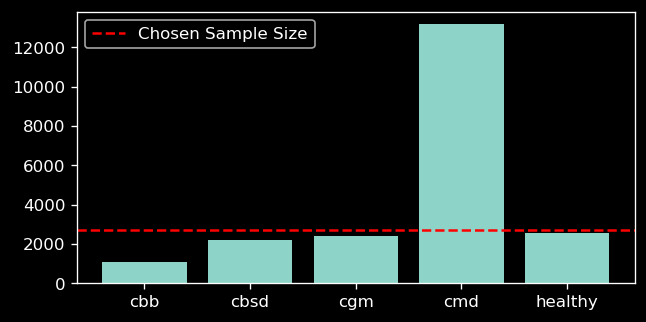

In [8]:
path = '../data/train_images_sorted'

img_flist = {}
img_quants = {}

for c in classes:
    files = get_image_files(f'{path}/{c}')
    img_flist[c] = list(files)
    img_quants[c] = len(files)

minqc = min(img_quants, key=img_quants.get)

sample_size = round(img_quants[minqc] * 2.5)  # oversample the lowest class quantity


plt.figure(figsize=(6,3))
plt.bar(img_quants.keys(), img_quants.values())  
plt.axhline(sample_size, ls='--', color='red', label='Chosen Sample Size')
plt.legend()
plt.show()
        

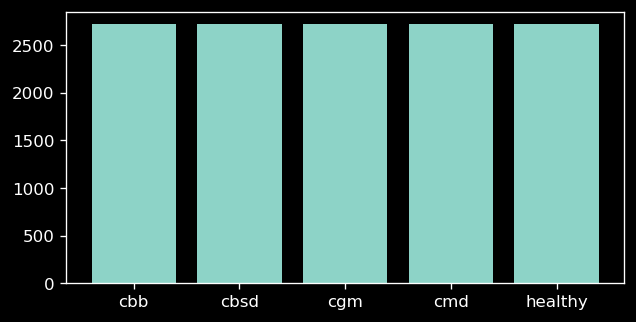

In [9]:

for c in classes:
    if len(img_flist[c]) < sample_size:
#         all_covid = img_flist[c].copy()
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], sample_size - len(img_flist[c]), replace=True))
    else:
        img_flist[c] = np.random.choice(img_flist[c], sample_size, replace=False)  # without replacement

    # boost the weak class
#     if c == 'healthy':
#         img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], round(sample_size * 0.5), replace=False))
        
plt.figure(figsize=(6,3))
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.show()

In [10]:
test_flist = {}
test_size = round(0.1 * sample_size)

for c in classes:
    img_flist[c] = np.random.choice(img_flist[c], len(img_flist[c]), replace=False)  # shuffle
    test_flist[c] = img_flist[c][0:test_size]
    img_flist[c] = img_flist[c][test_size:]
#     img_flist[c] = [f for f in img_flist[c] if f not in test_flist[c]]

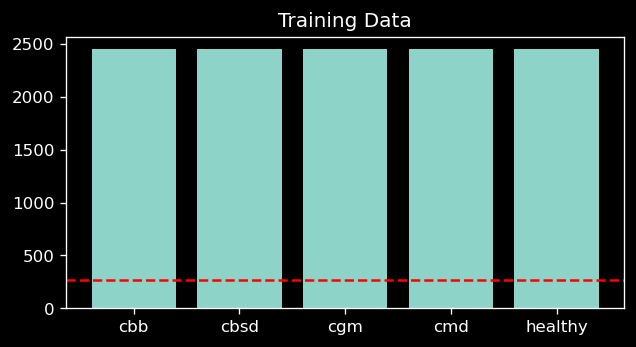

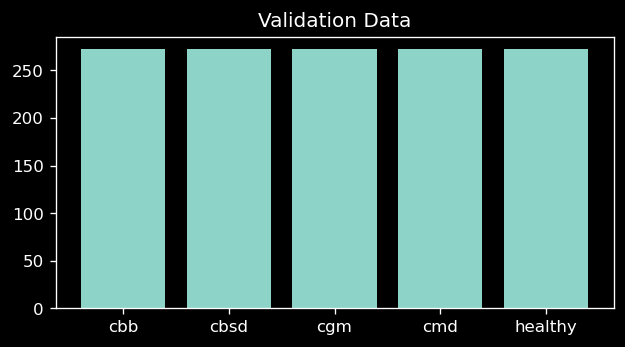

In [11]:
plt.figure(figsize=(6,3))
plt.title('Training Data')
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.axhline(test_size, ls='--', color='red')
plt.show()

plt.figure(figsize=(6,3))
plt.title('Validation Data')
plt.bar(test_flist.keys(), [len(l) for l in test_flist.values()])
plt.show()
                 

In [12]:
def get_fnames(path):
    retlist = []
    
    for l in img_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

# batch_tfms = [ *aug_transforms(size=round(RESOLUTION * 1), do_flip=True, batch=True, max_zoom=1.7, mult=2.4), Normalize.from_stats(*imagenet_stats) ]
batch_tfms = [ Normalize.from_stats(*imagenet_stats)]  #, 
#               *aug_transforms(size=RESOLUTION, do_flip=True, batch=False, max_lighting=0.2,
#                                max_rotate=45, max_zoom=2.5, mult=2.0, max_warp=0.1)]

# batch_tfms = [ *aug_transforms(size=round(RESOLUTION * 1), do_flip=True, batch=True, p_affine=0.5, p_lighting=0.5,
#     max_warp=0.1, max_zoom=1.7, mult=2), Normalize.from_stats(*imagenet_stats) ]


img_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
#     item_tfms=Resize(RESOLUTION, method='bilinear') , batch_tfms=batch_tfms)
    item_tfms=RandomResizedCrop(RESOLUTION) , batch_tfms=batch_tfms)

dls = img_db.dataloaders(path, batch_size=BATCH_SIZE)

<br>

### Verify the Training and Validation Batches

examples from the training set


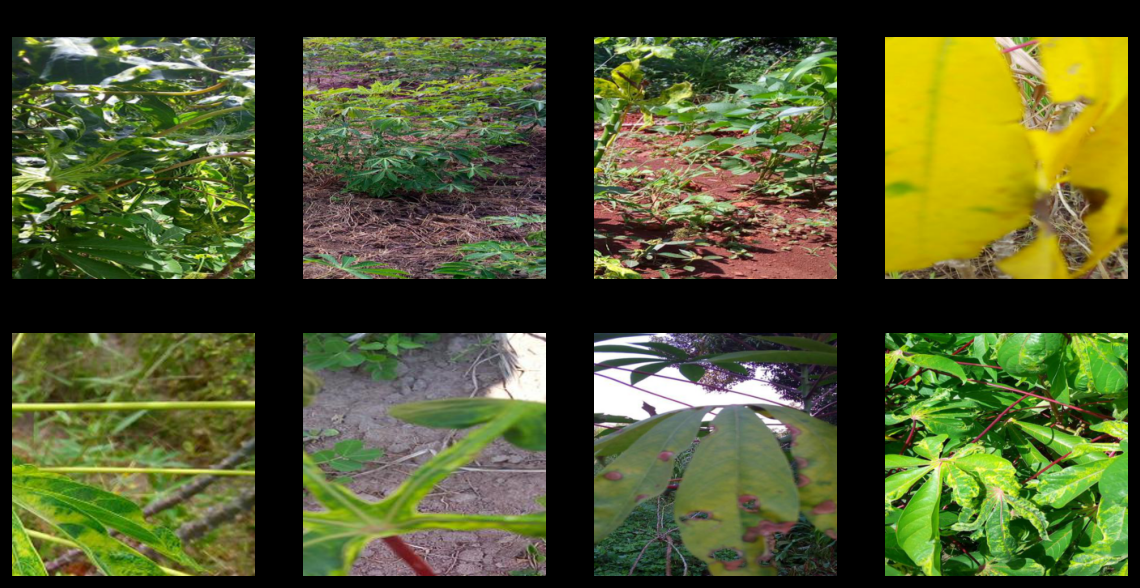

In [13]:
print('examples from the training set')
dls.train.show_batch(max_n=8, nrows=2)


examples from the validation set


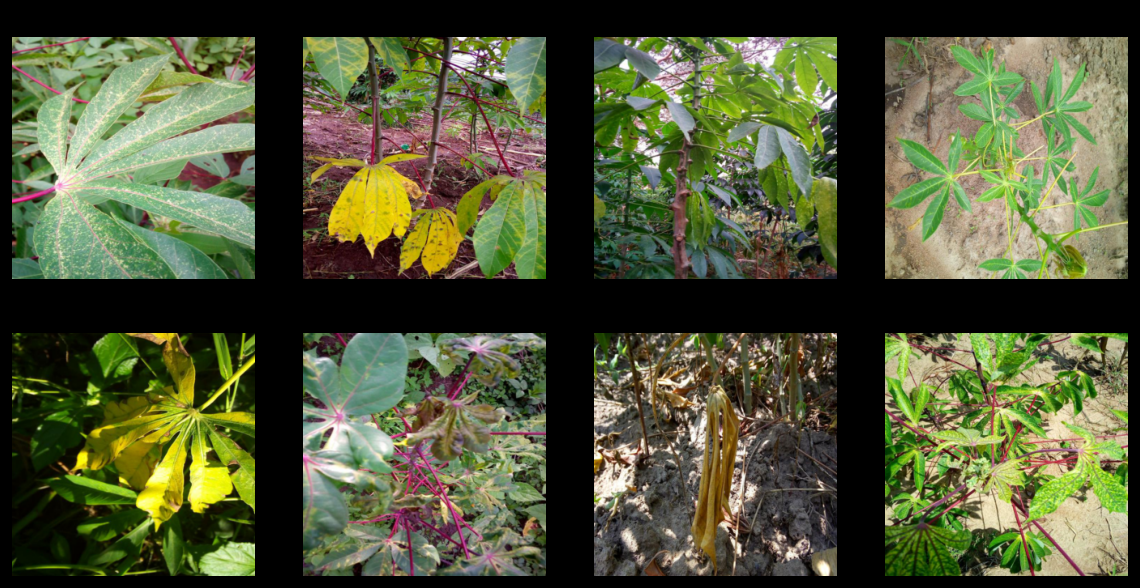

In [14]:
print('\nexamples from the validation set')
dls.valid.show_batch(max_n=8, nrows=2)

In [15]:
# Eary stopping callback
early_stop_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=5)

# Save the current model's weights every epoch
save_cb = SaveModelCallback(fname=RUN_NAME, every_epoch=True, with_opt=True)

# Reduce the Learning Rate if valid_loss flatlines
reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=1, factor=4, reset_on_fit=False)

# Mixup callback for regularization
# mixup_cb = MixUp(alpha=0.4)
mixup_cb = None

# Cutmix callback for regularization
# cutmix_cb = CutMix(alpha=0.5)
cutmix_cb = None

# Gradient Accumulation
# gradacc_cb =  GradientAccumulation(n_acc=16)
gradacc_cb =  GradientAccumulation(n_acc=256)


# List of callbacks to be used later
cbs = [save_cb, GradientClip, gradacc_cb, reduceLR_cb, ShowGraphCallback()]

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)




print('\nAll Callbacks: ', cbs)


All Callbacks:  [SaveModelCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation, ReduceLROnPlateau, ShowGraphCallback]


### Visualize the effect of CutMix


In [16]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')


 CutMix was not selected.


<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [17]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


In [18]:
# learn = cnn_learner(dls, ARCH , 
#                     pretrained=PRETRAINED_FLAG, wd=1e-4, opt_func=ranger,
#                     loss_func=LabelSmoothingCrossEntropyFlat(), 
#                     cbs = cbs, metrics=[error_rate, accuracy])

# from wwf.vision.timm import *
import timm
learn = timm_learner(dls, 
                    'efficientnet_b4',
                     opt_func=ranger,
                     loss_func=LabelSmoothingCrossEntropyFlat(),
                     cbs=cbs, pretrained=False,
                     metrics = [accuracy]) # .to_fp16()



In [19]:
# Add custom weights to learn

# learn = load_learner(f'../models/{RUN_NAME_OF_MODEL_TO_LOAD}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # doesn't exist!
learn.model = convert_act_cls(learn.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the last layers
learn.model = convert_act_cls(learn.model, nn.SiLU, SwishAuto())  # replace with a lower memory version


# learn.model[0] = convert_seq_chkpt(learn.model[0], nn.Sequential) #, 0)  # wrap all BODY sequentials to use Gradient Checkpointing
# learn.model[0] = nn.Sequential(CheckpointModule(learn.model[0], 1))  # hack in the final checkpointmodule for the base sequence

learn = learn.to_fp16()  # convert to 16bit

In [20]:
display(learn.loss_func, learn.opt_func, learn.cbs) #, '-------------------------------------', learn.model)  # Checkpoint

FlattenedLoss of LabelSmoothingCrossEntropy()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

(#9) [TrainEvalCallback,Recorder,ProgressCallback,SaveModelCallback,GradientClip,GradientAccumulation,ReduceLROnPlateau,ShowGraphCallback,MixedPrecision]

In [21]:
learn.model[1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1792, out_features=512, bias=False)
  (5): MishAuto()
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=False)
)

In [22]:
# # RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)



<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [ ]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [ ]:
# from apex.fp16_utils import convert_network
# learn.model = convert_network(learn.model, torch.float16)

In [ ]:
# learn = learn.to_fp16()

In [ ]:
if PRETRAINED_FLAG == True:
    learn.unfreeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [23]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
LR_CHOICE = slice(4e-6, 3e-4)
# LR_CHOICE = 2e-4
# LR_CHOICE = 7e-2
# LR_CHOICE=1e-3

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [24]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

EPOCHS:         60
Learning Rate:  slice(4e-06, 0.0003, None)




In [25]:
if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

## Manually set up the unfrozen runs

In [26]:
learn.unfreeze()

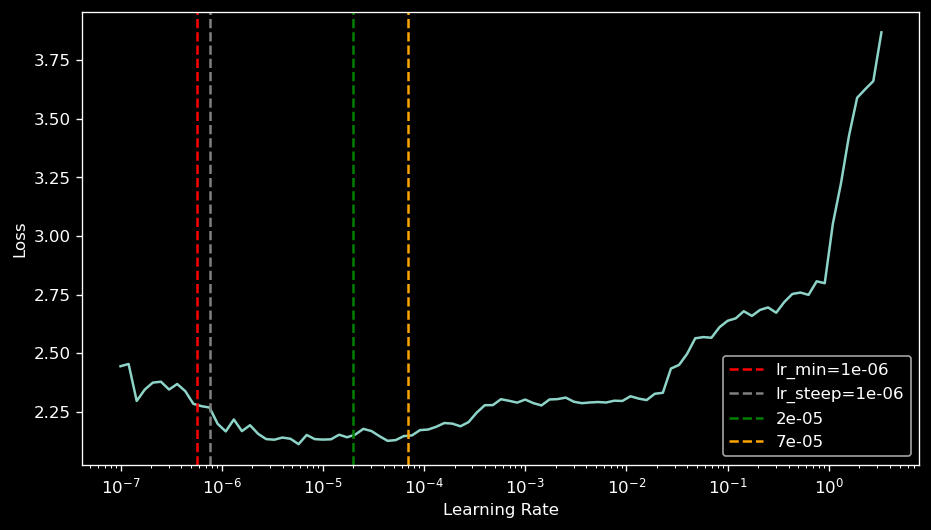

In [32]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")  #, LR_CHOICE/2: {LR_CHOICE / 2}")

## Pick a new Learning Rate

In [34]:
# LR_CHOICE_UNFROZ = lr_min/LR_DIV
# LR_CHOICE_UNFROZ = LR_CHOICE / 2
# LR_CHOICE_UNFROZ = 0.00015
# LR_CHOICE_UNFROZ = 10e-5
# LR_CHOICE_UNFROZ = 0.00008
# LR_CHOICE_UNFROZ = 5.5e-5
# LR_CHOICE_UNFROZ = 1.7e-4
# LR_CHOICE_UNFROZ = 6e-5
# LR_CHOICE_UNFROZ = lr_min
# LR_CHOICE_UNFROZ = 1e-3
# LR_CHOICE_UNFROZ = 2e-5
# LR_CHOICE_UNFROZ = lr_steep
# LR_CHOICE_UNFROZ = 7e-4

LR_CHOICE_UNFROZ = slice(1e-5, 1e-2)

### Train

In [35]:
EPOCHS = 10

In [36]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         10
Learning Rate:  slice(1e-05, 0.01, None)




epoch,train_loss,valid_loss,accuracy,time
0,1.916325,1.659623,0.220496,12:46
1,1.759467,1.668438,0.231126,12:22
2,1.735307,1.612223,0.223767,12:09
3,1.666860,1.620318,0.232488,12:08
4,1.648376,1.658769,0.232761,12:05
5,1.635258,1.602566,0.234396,12:08
6,1.622326,1.601904,0.233579,12:09
7,1.616268,1.594451,0.238212,12:09
8,1.615800,1.593665,0.244481,12:09
9,1.611188,1.594423,0.242028,12:08


Epoch 0: reducing lr to 0.0024495233412705204


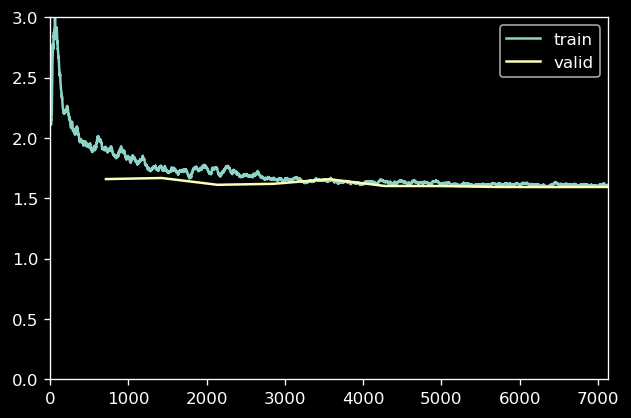

Epoch 1: reducing lr to 0.002279913289908844
Epoch 3: reducing lr to 0.001659369053187215
Epoch 4: reducing lr to 0.0012704009589714956
Epoch 5: reducing lr to 0.000879396806533654
Epoch 7: reducing lr to 0.00024376464215261325
Epoch 8: reducing lr to 6.260918215865137e-05
Epoch 9: reducing lr to 2.5123820907805433e-08
Max GPU Memory Allocated: 2.980868096 GB


/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [37]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.01, wd=1e-2)
print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

<br>
<br>

<br>
<br>

### Train again

In [ ]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
    # RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
    # EPOCH_TO_LOAD = 9

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_9.pth', learn, opt=ranger, with_opt=False)

In [ ]:
learn.unfreeze()

In [ ]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [ ]:
EPOCHS = 12
LR_CHOICE_UNFROZ = slice(3e-4, 1e-6)

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=0.1) # , reset_opt=True)
print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()


<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

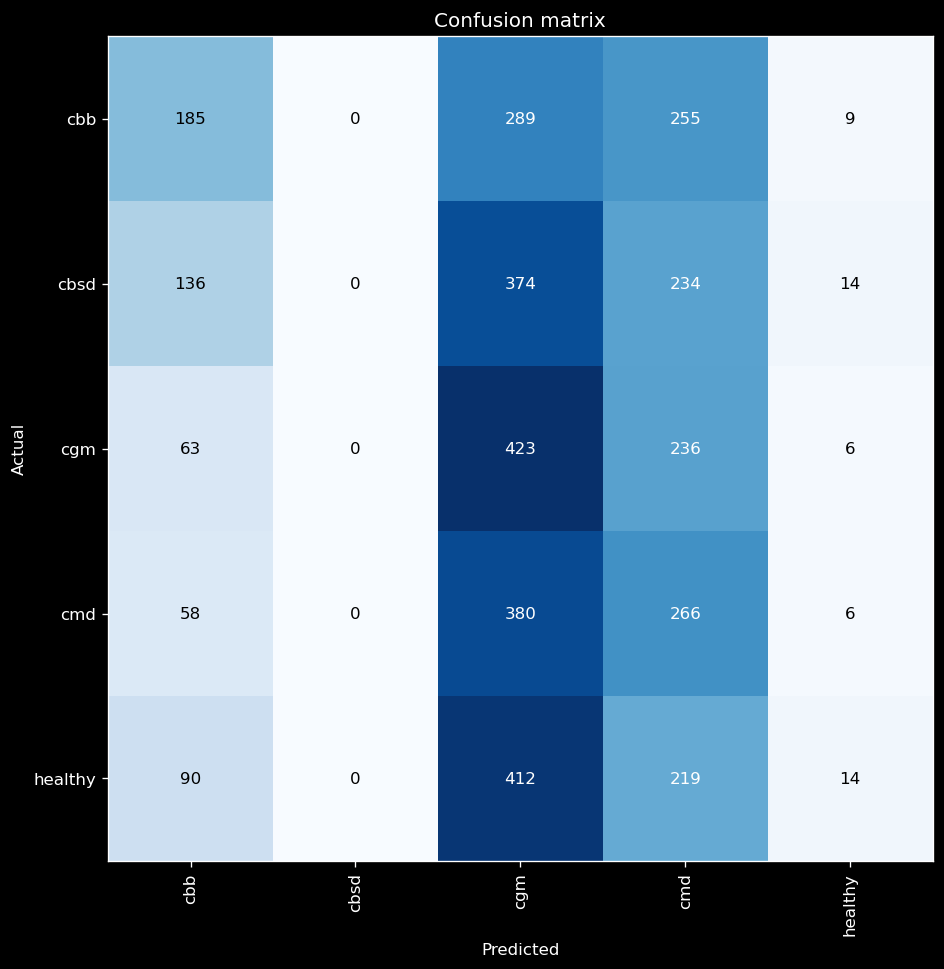

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

## Validation

In [ ]:
test_learn = learn

# load_learner('../models/20210205-1716 - arch=xresnet34 - samples=1800 frozen=1 epochs=40 bs=32 res=340.pkl', cpu=False)
load_model(f'models/{RUN_NAME}_9.pth', test_learn, opt=ranger, with_opt=False)


In [ ]:
def get_test_fnames(path):
    retlist = []
    
    for l in test_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=Resize(RESOLUTION, method='bilinear'), batch_tfms=batch_tfms) #,
#     item_tfms=CropPad(RESOLUTION, pad_mode='zeros'))
#    ,    batch_tfms=aug_transforms(do_flip=True, size=RESOLUTION, batch=False, max_zoom=1.0, mult=1, pad_mode='zeros'))


dls = test_db.dataloaders(get_test_fnames, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
# !sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('EFB4 Cassava Disease Classification-Copy2.ipynb', f'.Archive/{time} - EFB4 Cassava Disease Classification-Copy2.ipynb')

## Infer on the Kaggle provided test set